# Intent Analysis

## Introduction

## Importing Libraries & Zemberek & Other Modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
import re , os, pickle
from pathlib import Path
import time
import logging

from zemberek import (
    TurkishSpellChecker,
    TurkishSentenceNormalizer,
    TurkishSentenceExtractor,
    TurkishMorphology,
    TurkishTokenizer
)

import torch
import random
import torch.nn as nn
import transformers
import gc
import tensorflow as tf
import matplotlib.pyplot as plt
device = torch.device('cuda')
import torch.nn.functional as F
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
#from torch.optim import Adam
from tqdm import tqdm
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score

c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Zemberek'i kullanabillmek için ilk önce java kütüphenelerini kullanmamızı sağlayan kütüphaneyi ekleyelim
import jpype as jp

import warnings
warnings.filterwarnings("ignore")

In [3]:
import zipfile

def read_jar(jar_file):
    zf = zipfile.ZipFile(jar_file, 'r')
    try:
        lst = zf.infolist()
        for zi in lst:
            fn = zi.filename 
            # print(fn)
    finally:
        zf.close()
        
read_jar(r"zemberek-full.jar")

In [4]:
# Zembrek'i çalıştıralım
ZEMBEREK_PATH = r'zemberek-full.jar'
jp.startJVM(jp.getDefaultJVMPath(), '-ea', '-Djava.class.path=%s' % (ZEMBEREK_PATH))

In [5]:
# Zemberekten gerekli modülleri import edelim
TurkishTokenizer = jp.JClass('zemberek.tokenization.TurkishTokenizer')
TurkishMorphology = jp.JClass('zemberek.morphology.TurkishMorphology')
TurkishSentenceExtractor = jp.JClass('zemberek.tokenization.TurkishSentenceExtractor')

morphology = TurkishMorphology.createWithDefaults()
tokenizer = TurkishTokenizer.ALL
extractor = TurkishSentenceExtractor.DEFAULT

In [6]:
Paths = jp.JClass('java.nio.file.Paths')
lookupRoot = Paths.get(r'normalization')
lmPath = Paths.get(r'lm.2gram.slm')

### Adding Stopwords

In [7]:
# zemberekten aldığımız stopword dosyasını kullanarak bu kelimeleri metinlerden çıkartacağız
stopwords = [x.strip() for x in open(r'stop-words.txt','r', encoding="UTF8").read().split('\n')]
stopwords[30:50]

['adilane',
 'afedersin',
 'afedersinin',
 'aferin',
 'affettuoso',
 'agitato',
 'agucuk',
 'ağababa',
 'ağabey',
 'ağır',
 'ağızdan',
 'ah',
 'aha',
 'ahacık',
 'ahbap',
 'aheste',
 'ahir',
 'ahiren',
 'ahlaken',
 'ailecek']

### Importing & Adjusting Dataset

In [8]:
with open('intent_tr.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
df_ = data.copy()

In [9]:
df = pd.DataFrame(df_['intents'])
df.head()

,intent,text,responses,extension,context,entityType,entities
0,Greetings,"[Merhaba, mrb, meraba, merb, Selam, slm, slmz,...","[Merhaba, lütfen GeniSys kullanıcı adınızı söy...","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': 'GreetingsHumanQuery', 'clea...",NA,[]
1,GreetingsResponse,"[Ben Teknr!, Adım Teknr, Benim Adım Teknr, Ban...",[Harika! Selamlar <KULLANICI>! Size nasıl yard...,"{'function': 'extensions.gHumans.updateHuman',...","{'in': 'GreetingsHumanQuery', 'out': '', 'clea...",NA,"[{'entity': 'KULLANICI', 'rangeFrom': 3, 'rang..."
2,ExistingHumanQuery,"[Adım ne?, Adımı hatırlıyor musun?, Kim olduğu...",[Senin adın <HUMAN>! Sana nasıl yardımcı olabi...,{'function': 'extensions.gHumans.getCurrentHum...,"{'in': '', 'out': 'CurrentHumanQuery', 'clear'...",NA,[]
3,WhatIsMyName,"[Adın ne?, Seni nasıl çağırabilirim?, Sana ne ...","[Adım Tek-nr!, Bana Tek-nr diyebilirsin, Lütfe...","{'function': '', 'entities': False, 'responses...","{'in': '', 'out': '', 'clear': False}",NA,[]
4,TimeAndDate,"[Saat kaç?, Saatin kaç olduğunu biliyor musun?...","[Bir dakika, Bir saniye, Biraz bekleteceğim., ...","{'function': 'extensions.gTime.getTime', 'enti...","{'in': '', 'out': '', 'clear': False}",NA,[]


In [10]:
df_patterns = df[['text','intent']]
df_responses = df[['responses', 'intent']]
df_patterns

,text,intent
0,"[Merhaba, mrb, meraba, merb, Selam, slm, slmz,...",Greetings
1,"[Ben Teknr!, Adım Teknr, Benim Adım Teknr, Ban...",GreetingsResponse
2,"[Adım ne?, Adımı hatırlıyor musun?, Kim olduğu...",ExistingHumanQuery
3,"[Adın ne?, Seni nasıl çağırabilirim?, Sana ne ...",WhatIsMyName
4,"[Saat kaç?, Saatin kaç olduğunu biliyor musun?...",TimeAndDate
5,"[Teşekkürler, Teşekkür ederim, Thx, Sağ ol, Sa...",ThankYou
6,"[Seninle konuşmuyordum., Sana söylemedim., Sen...",IDontTalkWithYou
7,"[Ne dediğimi anladın mı?, Beni anlıyor musun?,...",DidYouUnderstand
8,"[Sessiz ol!, Çeneni kapat!, Çeneni kapa!, Sus!...",ShutUp
9,"[Siktir git, oc, orospu çocuğu, kaşar, yavşak,...",Swear


In [11]:
df_patterns = df_patterns.explode('text')
df_patterns.head()

,text,intent
0,Merhaba,Greetings
0,mrb,Greetings
0,meraba,Greetings
0,merb,Greetings
0,Selam,Greetings


## Explatory Data Analysis

In [12]:
# Displaying Information About Dataset
df_patterns.info()

<class 'pandas.core.frame.DataFrame'>
Index: 272 entries, 0 to 23
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    272 non-null    object
 1   intent  272 non-null    object
dtypes: object(2)
memory usage: 6.4+ KB


In [13]:
df_patterns.describe().T

,count,unique,top,freq
text,272,270,Saat kaç?,2
intent,272,24,Greetings,42


In [14]:
# How Many Texts Are There?
df_patterns.text.count()

272

In [15]:
# How Many Intents Are There?
intent_counts = df_patterns.groupby("intent").size().reset_index(name="count")
intent_counts

,intent,count
0,BookingAppointments,10
1,ComplaintsFeedback,20
2,CourtesyGoodBye,6
3,DidYouUnderstand,6
4,ExistingHumanQuery,8
5,GoodBye,11
6,Gossip,7
7,Greetings,42
8,GreetingsResponse,4
9,HelpRequest,10


In [16]:
# Is There Any Null Value?
df_patterns.isnull().sum()

text      0
intent    0
dtype: int64

In [17]:
# Is There Any Duplicated Value?
df_patterns.duplicated().any()

True

In [18]:
df_patterns.text.is_unique

False

In [19]:
df_patterns[df_patterns.text.duplicated(keep=False)]

,text,intent
3,İsmin ne?,WhatIsMyName
3,İsmin ne?,WhatIsMyName
4,Saat kaç?,TimeAndDate
4,Saat kaç?,TimeAndDate


In [20]:
df_patterns.drop_duplicates(subset='text', inplace=True)

In [21]:
df_patterns.describe().T

,count,unique,top,freq
text,270,270,Merhaba,1
intent,270,24,Greetings,42


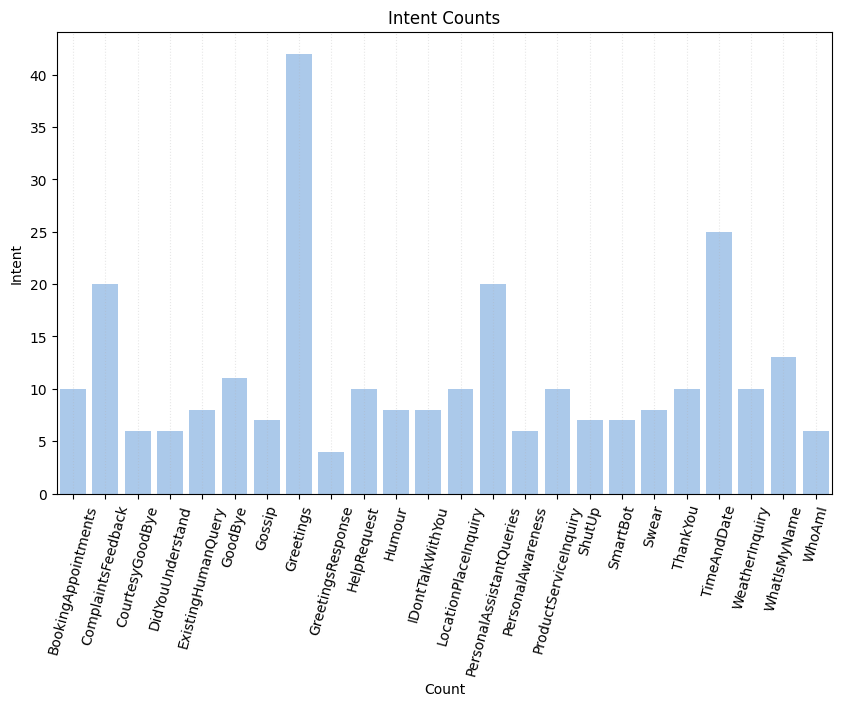

In [22]:
sns.set_palette("pastel")
plt.figure(figsize=(10, 6))
plt.xticks(rotation=75)
sns.barplot(x="intent", y="count", data=intent_counts, orient="v")
plt.title('Intent Counts')
plt.xlabel('Count')
plt.ylabel('Intent')
plt.grid(axis='x', linestyle=':', alpha=0.3)

In [23]:
intent_counts["count"].median()

9.0

In [24]:
df_copy = df_patterns.copy()
df_copy.head()

,text,intent
0,Merhaba,Greetings
0,mrb,Greetings
0,meraba,Greetings
0,merb,Greetings
0,Selam,Greetings


## Data Pre-Processing

In [25]:
import data_preprocessing as prep

In [26]:
df_patterns['clean_text'] = df_patterns['text'].apply(lambda x : prep.data_cleaning(x))
df_patterns

,text,intent,clean_text
0,Merhaba,Greetings,merhaba
0,mrb,Greetings,mrb
0,meraba,Greetings,meraba
0,merb,Greetings,merb
0,Selam,Greetings,selam
...,...,...,...
23,Bu ürünün renk seçenekleri neler?,ProductServiceInquiry,bu ürünün renk seçenekleri neler
23,Ürün iadesi nasıl yapılır?,ProductServiceInquiry,ürün iadesi nasıl yapılır
23,Bu hizmet ne zaman başlıyor?,ProductServiceInquiry,bu hizmet ne zaman başlıyor
23,Bu paketin içeriğinde neler var?,ProductServiceInquiry,bu paketin içeriğinde neler var


In [27]:
df_patterns['clean_sw'] = df_patterns['text'].apply(lambda x: prep.remove_stopwords(x, stopwords))
df_patterns

,text,intent,clean_text,clean_sw
0,Merhaba,Greetings,merhaba,
0,mrb,Greetings,mrb,mrb
0,meraba,Greetings,meraba,meraba
0,merb,Greetings,merb,merb
0,Selam,Greetings,selam,selam
...,...,...,...,...
23,Bu ürünün renk seçenekleri neler?,ProductServiceInquiry,bu ürünün renk seçenekleri neler,ürünün renk seçenekleri neler
23,Ürün iadesi nasıl yapılır?,ProductServiceInquiry,ürün iadesi nasıl yapılır,ürün iadesi yapılır
23,Bu hizmet ne zaman başlıyor?,ProductServiceInquiry,bu hizmet ne zaman başlıyor,hizmet zaman başlıyor
23,Bu paketin içeriğinde neler var?,ProductServiceInquiry,bu paketin içeriğinde neler var,paketin içeriğinde neler var


In [28]:
df_patterns['clean_sw'][:10]

0            
0         mrb
0      meraba
0        merb
0       selam
0         slm
0        slmz
0      selaam
0       naber
0    nabersin
Name: clean_sw, dtype: object

In [29]:
df_patterns['word_token'] = df_patterns['clean_text'].apply(lambda x: prep.word_tokenize(x))
df_patterns

,text,intent,clean_text,clean_sw,word_token
0,Merhaba,Greetings,merhaba,,[merhaba]
0,mrb,Greetings,mrb,mrb,[mrb]
0,meraba,Greetings,meraba,meraba,[meraba]
0,merb,Greetings,merb,merb,[merb]
0,Selam,Greetings,selam,selam,[selam]
...,...,...,...,...,...
23,Bu ürünün renk seçenekleri neler?,ProductServiceInquiry,bu ürünün renk seçenekleri neler,ürünün renk seçenekleri neler,"[bu, ürünün, renk, seçenekleri, neler]"
23,Ürün iadesi nasıl yapılır?,ProductServiceInquiry,ürün iadesi nasıl yapılır,ürün iadesi yapılır,"[ürün, iadesi, nasıl, yapılır]"
23,Bu hizmet ne zaman başlıyor?,ProductServiceInquiry,bu hizmet ne zaman başlıyor,hizmet zaman başlıyor,"[bu, hizmet, ne, zaman, başlıyor]"
23,Bu paketin içeriğinde neler var?,ProductServiceInquiry,bu paketin içeriğinde neler var,paketin içeriğinde neler var,"[bu, paketin, içeriğinde, neler, var]"


In [30]:
def lemmas(word_list):
    lemma = []
    for word in word_list:
        result = str(morphology.analyzeAndDisambiguate(word).bestAnalysis()[0].getLemmas()[0])
        if result == "UNK":
            lemma.append(result)
        else:
            lemma.append(result)
    return lemma

In [31]:
df_patterns['lemma_token'] = df_patterns['word_token'].apply(lambda x : lemmas(x))
df_patterns

,text,intent,clean_text,clean_sw,word_token,lemma_token
0,Merhaba,Greetings,merhaba,,[merhaba],[merhaba]
0,mrb,Greetings,mrb,mrb,[mrb],[UNK]
0,meraba,Greetings,meraba,meraba,[meraba],[meraba]
0,merb,Greetings,merb,merb,[merb],[UNK]
0,Selam,Greetings,selam,selam,[selam],[selam]
...,...,...,...,...,...,...
23,Bu ürünün renk seçenekleri neler?,ProductServiceInquiry,bu ürünün renk seçenekleri neler,ürünün renk seçenekleri neler,"[bu, ürünün, renk, seçenekleri, neler]","[bu, ürün, renk, seçenek, ne]"
23,Ürün iadesi nasıl yapılır?,ProductServiceInquiry,ürün iadesi nasıl yapılır,ürün iadesi yapılır,"[ürün, iadesi, nasıl, yapılır]","[ürün, iade, nasıl, yap]"
23,Bu hizmet ne zaman başlıyor?,ProductServiceInquiry,bu hizmet ne zaman başlıyor,hizmet zaman başlıyor,"[bu, hizmet, ne, zaman, başlıyor]","[bu, hizmet, ne, zaman, başla]"
23,Bu paketin içeriğinde neler var?,ProductServiceInquiry,bu paketin içeriğinde neler var,paketin içeriğinde neler var,"[bu, paketin, içeriğinde, neler, var]","[bu, paket, içerik, ne, var]"


In [32]:
df_patterns['target'], mapping = pd.factorize(df_patterns.intent)
df_patterns

,text,intent,clean_text,clean_sw,word_token,lemma_token,target
0,Merhaba,Greetings,merhaba,,[merhaba],[merhaba],0
0,mrb,Greetings,mrb,mrb,[mrb],[UNK],0
0,meraba,Greetings,meraba,meraba,[meraba],[meraba],0
0,merb,Greetings,merb,merb,[merb],[UNK],0
0,Selam,Greetings,selam,selam,[selam],[selam],0
...,...,...,...,...,...,...,...
23,Bu ürünün renk seçenekleri neler?,ProductServiceInquiry,bu ürünün renk seçenekleri neler,ürünün renk seçenekleri neler,"[bu, ürünün, renk, seçenekleri, neler]","[bu, ürün, renk, seçenek, ne]",23
23,Ürün iadesi nasıl yapılır?,ProductServiceInquiry,ürün iadesi nasıl yapılır,ürün iadesi yapılır,"[ürün, iadesi, nasıl, yapılır]","[ürün, iade, nasıl, yap]",23
23,Bu hizmet ne zaman başlıyor?,ProductServiceInquiry,bu hizmet ne zaman başlıyor,hizmet zaman başlıyor,"[bu, hizmet, ne, zaman, başlıyor]","[bu, hizmet, ne, zaman, başla]",23
23,Bu paketin içeriğinde neler var?,ProductServiceInquiry,bu paketin içeriğinde neler var,paketin içeriğinde neler var,"[bu, paketin, içeriğinde, neler, var]","[bu, paket, içerik, ne, var]",23


In [33]:
df__ = prep.balance_data(df_patterns)
df__

,text,intent,clean_text,clean_sw,word_token,lemma_token,target
0,Merhaba,Greetings,merhaba,,[merhaba],[merhaba],0
0,mrb,Greetings,mrb,mrb,[mrb],[UNK],0
0,meraba,Greetings,meraba,meraba,[meraba],[meraba],0
0,merb,Greetings,merb,merb,[merb],[UNK],0
0,Selam,Greetings,selam,selam,[selam],[selam],0
...,...,...,...,...,...,...,...
27,Bu hizmetin maliyeti ne kadar?,ProductServiceInquiry,bu hizmetin maliyeti ne kadar,hizmetin maliyeti,"[bu, hizmetin, maliyeti, ne, kadar]","[bu, hizmet, maliyet, ne, kadar]",23
28,Ürün garantisi var mı?,ProductServiceInquiry,ürün garantisi var mı,ürün garantisi var,"[ürün, garantisi, var, mı]","[ürün, garanti, var, mı]",23
29,Bu hizmetin maliyeti ne kadar?,ProductServiceInquiry,bu hizmetin maliyeti ne kadar,hizmetin maliyeti,"[bu, hizmetin, maliyeti, ne, kadar]","[bu, hizmet, maliyet, ne, kadar]",23
30,Bu hizmet ne zaman başlıyor?,ProductServiceInquiry,bu hizmet ne zaman başlıyor,hizmet zaman başlıyor,"[bu, hizmet, ne, zaman, başlıyor]","[bu, hizmet, ne, zaman, başla]",23


## Building a Model

In [34]:
X = df__.drop(["target"], axis=1)
y = df__["target"]

In [35]:
# Veriyi eğitim ve test kümelerine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [36]:
train_corpus = np.array([' '.join(tokens) for tokens in X_train.lemma_token])

In [37]:
train_corpus

array(['hafta son hava durum nasıl', 'anla mı', 'doğum gün hatırla kur',
       'bu hafta hangi gün tatil', 'sus', 'akıl', 'UNK UNK', 'UNK',
       'bu iş nasıl yap anla yardım et mi', 'ses ol', 'bura adres ne',
       'bura adres ne', 'hava bugün güneş mi', 'dedikodu var mı',
       'çene kapa', 'ben bir şaka yap', 'UNK', 'tamam mı', 'bayağı zeki',
       'konuş', 'trafik durum nasıl', 'bura posta kod ne',
       'nasıl yap bil yardımcı ol mu', 'şu an konum en yakın otel nere',
       'trafik durum nasıl', 'ben gerçek ad söyle', 'sen konuş',
       'sen söyle', 'bu hizmet maliyet ne kadar', 'ba zeki', 'UNK',
       'sağ ol görüş', 'b', 'sağ ol bay bay', 'kaşar',
       'yarın yağmur yağ mı', 'ben UNK de', 'yarın hangi gün', 'akıl',
       'en yakın kuru temizle nere', 'bir toplantı ayarla mi', 'sağol',
       'akşam hava soğuk ol mı', 'bu hafta hangi gün tatil',
       'yakın çevre kafe göster', 'lütfen bilinç ol kanıt', 'dahi',
       'sıkıl ben dedikodu yap', 'ben gör mu', 'ben anla

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorize = CountVectorizer()
sparce_matrix = count_vectorize.fit_transform(train_corpus).toarray()
sparce_matrix = (sparce_matrix - sparce_matrix.min())/(sparce_matrix.max() - sparce_matrix.min())

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vector = TfidfVectorizer()
tfidf_matrix = tfidf_vector.fit_transform(train_corpus).toarray()

In [40]:
attribution = (tfidf_matrix, sparce_matrix) 
attribution = np.concatenate(attribution, axis = 1)
X_train = attribution

In [41]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [42]:
test_corpus = np.array([' '.join(tokens) for tokens in X_test.lemma_token])
test_corpus

array(['eyvallah', 'ne de bil mu', 'yarın hava güneş mi ol', 'saat kaç',
       'bok', 'UNK UNK', 'paket hasar gel nasıl değiş', 'alarm ye kur',
       'UNK', 'yarın toplantı hatırla', 'yarın hava güneş mi ol',
       'bu ürün stok var mı', 'UNK', 'kim ben', 'kim sen',
       'bu hafta hangi gün tatil', 'bilinç ol kanıt', 'ben kamera gör mu',
       'bir toplantı ayarla mi', 'akıl kız', 'bu ürün stok var mı',
       'ben kamera gör mu', 'doktor randevu al mi', 'ne haber',
       'ne benze', 'bugün sıcaklık kaç derece', 'UNK', 'gerçek ad ne',
       'bura adres ne', 'kaşar', 'teşekkür', 'UNK',
       'bu ürün beklenti karşıla ne yap', 'sen için söyle',
       'yarın hangi gün', 'bu ürün fiyat ne', 'adım UNK', 'UNK',
       'ben UNK de', 'teslimat seçenek ne',
       'tiyatro bilet için rezervasyon yap mi', 'biraz dedikodu duy iste',
       'bu konu ben rehber et mi', 'tamam mı', 'adım UNK', 'UNK görüş',
       'ben gör mu', 'hava bugün güneş mi', 'saat kaç ol bil mu',
       'teşekkür',

In [43]:
test_sparce_matrix = count_vectorize.transform(test_corpus).toarray()
test_sparce_matrix = (test_sparce_matrix - test_sparce_matrix.min())/(test_sparce_matrix.max() - test_sparce_matrix.min())

In [44]:
test_tfidf_matrix = tfidf_vector.transform(test_corpus).toarray()

In [45]:
test_attribution = (test_tfidf_matrix, test_sparce_matrix) 
test_attribution = np.concatenate(test_attribution, axis = 1)
X_test = test_attribution
X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [46]:
x_train, x_test = X_train.reshape(-1, 1, X_train.shape[1]), X_test.reshape(-1, 1, X_train.shape[1])

In [60]:
def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.round(y_pred)

    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))

    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())

    f1_val = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1_val


In [61]:
# LSTM modeli oluşturulur
model=Sequential()
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(mapping), activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#Modelin Derlenmesi
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', f1_score])

# Erken durdurma ekleme
es = EarlyStopping(monitor='val_accuracy', 
                   mode='max', 
                   patience=20, # Ardışık 20 Epoch'ta val_accuracy artmazsa model eğitimini durdurur
                   restore_best_weights=True)

In [62]:
history = model.fit(x_train, y_train, batch_size=64, epochs=1000, callbacks=[es], validation_split=0.2)

Epoch 1/1000


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.0568 - f1_score: 0.0000e+00 - loss: 3.1752 - val_accuracy: 0.2148 - val_f1_score: 0.0000e+00 - val_loss: 3.1666
Epoch 2/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2381 - f1_score: 0.0000e+00 - loss: 3.1604 - val_accuracy: 0.4444 - val_f1_score: 0.0000e+00 - val_loss: 3.1536
Epoch 3/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3722 - f1_score: 0.0000e+00 - loss: 3.1454 - val_accuracy: 0.5185 - val_f1_score: 0.0000e+00 - val_loss: 3.1389
Epoch 4/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5404 - f1_score: 0.0000e+00 - loss: 3.1276 - val_accuracy: 0.5852 - val_f1_score: 0.0000e+00 - val_loss: 3.1217
Epoch 5/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5976 - f1_score: 0.0000e+00 - loss: 3.1077 - val_accuracy: 0.6222 - val_f1_score: 0.0000e+00 - val_loss: 3.0996
Epoch 6/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6766 - f1_score: 0.0000e+00 - loss: 3.0770 - val_accuracy: 0.63

In [65]:
print("Eğitim sonuçları:")
print("Accuracy: {:.2f}".format(history.history['accuracy'][-1]))
print("Validation Accuracy: {:.2f}".format(history.history['val_accuracy'][-1]))
print("F1 Score: {:.2f}".format(history.history['f1_score'][-1]))
print("Validation F1 Score: {:.2f}".format(history.history['val_f1_score'][-1]))

Eğitim sonuçları:
Accuracy: 0.93
Validation Accuracy: 0.89
F1 Score: 0.95
Validation F1 Score: 0.92
